# Wikipedia Notable Life Expectancies

# [Notebook 5 of : Data Cleaning](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_data_clean4_thanak_2022_06_23.ipynb)

## Context

The


## Objective

The

### Data Dictionary

- Feature: Description

## Importing Necessary Libraries

In [1]:
# To structure code automatically
%load_ext nb_black

# To import/export sqlite databases
import sqlite3 as sql

# To save/open python objects in pickle file
import pickle

# To help with reading, cleaning, and manipulating data
import pandas as pd
import numpy as np
import re

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)
# To define the maximum number of rows to be displayed in a dataframe
pd.set_option("display.max_rows", 200)

# To supress warnings
# import warnings

# warnings.filterwarnings("ignore")

# To set some visualization attributes
pd.set_option("max_colwidth", 150)

# To play auditory cue when cell has executed, has warning, or has error and set chime theme
import chime

chime.theme("zelda")

<IPython.core.display.Javascript object>

## Data Overview

### Reading, Sampling, and Checking Data Shape

In [2]:
# Reading the dataset
conn = sql.connect("wp_life_expect_clean3.db")
data = pd.read_sql("SELECT * FROM wp_life_expect_clean3", conn)

# Making a working copy
df = data.copy()

# Checking the shape
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns.")

# Checking first 2 rows of the data
df.head(2)

There are 132652 rows and 24 columns.


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy
0,1,William Chappell,", 86, British dancer, ballet designer and director.",https://en.wikipedia.org/wiki/William_Chappell_(dancer),21,1994,January,None,None,dancer,ballet designer director,None,None,None,None,None,None,None,None,86.0,None,United Kingdom of Great Britain and Northern Ireland,None,None
1,1,Raymond Crotty,", 68, Irish economist, writer, and academic.",https://en.wikipedia.org/wiki/Raymond_Crotty,12,1994,January,None,None,economist,writer,and academic,None,None,None,None,None,None,None,68.0,None,Ireland,None,None


<IPython.core.display.Javascript object>

In [3]:
# Checking last 2 rows of the data
df.tail(2)

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy
132650,9,Oleg Moliboga,", 69, Russian volleyball player, Olympic champion and coach.",https://en.wikipedia.org/wiki/Oleg_Moliboga,2,2022,June,,None,volleyball player,Olympic champion coach,None,None,None,None,None,None,None,None,69.0,None,Russia,None,1980
132651,9,Zou Jing,", 86, Chinese engineer, member of the Chinese Academy of Engineering.",https://en.wikipedia.org/wiki/Zou_Jing_(engineer),3,2022,June,None,None,engineer,member of the Academy of Engineering,None,None,None,None,None,None,None,None,86.0,None,"China, People's Republic of",None,None


<IPython.core.display.Javascript object>

In [4]:
# Checking a sample of the data
df.sample(5)

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy
14310,2,Georg Tintner,", 82, Austrian-born conductor, suicide.",https://en.wikipedia.org/wiki/Georg_Tintner,8,1999,October,None,None,conductor,suicide,None,None,None,None,None,None,None,None,82.0,None,Austria,None,None
110171,28,William Wolf,", 94, American author and theater critic, COVID-19.",https://en.wikipedia.org/wiki/William_Wolf_(critic),3,2020,March,None,None,author theater critic,COVID,None,None,None,None,None,None,None,None,94.0,None,United States of America,None,None
47021,25,Rudy Rufer,", 84, American baseball player .",https://en.wikipedia.org/wiki/Rudy_Rufer,1,2010,October,Giants,None,baseball player,None,None,None,None,None,None,None,None,None,84.0,None,United States of America,United States of America,Giants
10121,5,Jan Voigt,", 69, Norwegian actor, dancer and museum director.",https://en.wikipedia.org/wiki/Jan_Voigt,7,1997,December,None,None,actor,dancer museum director,None,None,None,None,None,None,None,None,69.0,None,Norway,None,None
7001,9,Aleksandar Popović,", 66, Serbian writer.",https://en.wikipedia.org/wiki/Aleksandar_Popovi%C4%87_(writer),6,1996,October,None,None,writer,None,None,None,None,None,None,None,None,None,66.0,None,Serbia,None,None


<IPython.core.display.Javascript object>

### Checking Data Types, Duplicates, and Null Values

In [5]:
# Checking data types and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132652 entries, 0 to 132651
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   day                132652 non-null  object 
 1   name               132652 non-null  object 
 2   info               132652 non-null  object 
 3   link               132652 non-null  object 
 4   num_references     132652 non-null  object 
 5   year               132652 non-null  int64  
 6   month              132652 non-null  object 
 7   info_parenth       49830 non-null   object 
 8   info_1             35 non-null      object 
 9   info_2             132604 non-null  object 
 10  info_3             62571 non-null   object 
 11  info_4             12605 non-null   object 
 12  info_5             1497 non-null    object 
 13  info_6             216 non-null     object 
 14  info_7             31 non-null      object 
 15  info_8             6 non-null       object 
 16  in

<IPython.core.display.Javascript object>

#### Observations:
- Due to the diversity of entries for `known_for`, we may need to prioritize entries for the extraction of this feature.
- To do so, we will proceed with typecasting num_references as integer, so we can determine which entries have more references.
- We will also make a copy of the `info_parenth` column, as we will alter that column and the information it contains is no longer present in the original `info` column.

#### Typecasting `num_references` as Integer

In [6]:
# Typecasting num_references as int64
df.loc[:, "num_references"] = df.loc[:, "num_references"].astype("int64")

<IPython.core.display.Javascript object>

#### Loading `nation_map` from Pickle File to Dictionary nation_map

In [7]:
# Load the nation_map
with open("nation_map.pkl", "rb") as f:
    nation_map = pickle.load(f)

<IPython.core.display.Javascript object>

### `num_references`

In [8]:
df["num_references"].describe()

count    132652.000000
mean          9.790406
std          19.436805
min           0.000000
25%           2.000000
50%           5.000000
75%          10.000000
max         837.000000
Name: num_references, dtype: float64

<IPython.core.display.Javascript object>

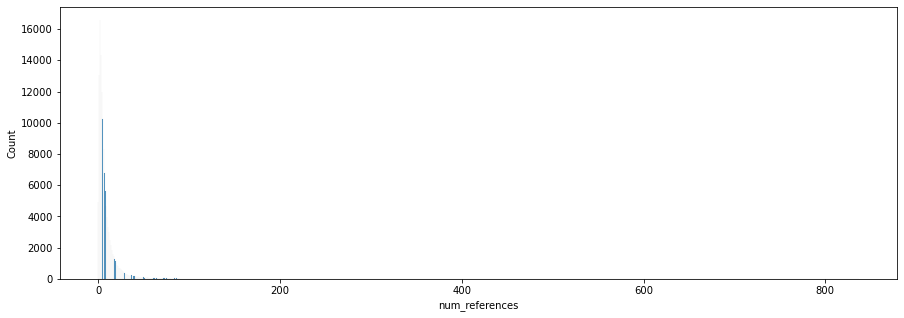

<IPython.core.display.Javascript object>

In [9]:
# Histplot of num_references
plt.figure(figsize=(15, 5))
sns.histplot(data=df, x="num_references")
plt.show()

#### Observations:
- The distribution of `num_references` is highly right skewed.
- We will verify some verifying of links to make sure the pages are for individuals.

In [10]:
# Example of verifying links (repeated in groups of 100 until num_references <100)
df.sort_values(by="num_references", ascending=False)[:10]

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy
36579,19,Bill Andress,", 83, American baseball umpire.",https://en.wikipedia.org/wiki/Bill_Andress,837,2008,May,None,None,baseball umpire,None,None,None,None,None,None,None,None,None,83.0,None,United States of America,None,None
11356,14,Frank Sinatra,", 82, American singer , heart attack.",https://en.wikipedia.org/wiki/Frank_Sinatra,660,1998,May,"""My Way"", ""That Life"" actor Oscar, winner",None,singer,heart attack,None,None,None,None,None,None,None,None,82.0,None,United States of America,None,"""My Way"", ""That Life"" actor Oscar, 1954 winner"
35265,17,Bobby Fischer,", 64, American chess grandmaster, world champion , kidney failure.",https://en.wikipedia.org/wiki/Bobby_Fischer,631,2008,January,,None,chess grandmaster,world champion,kidney failure,None,None,None,None,None,None,None,64.0,None,United States of America,None,1972 1975
26014,11,Keith Miller,", 84, Australian Test cricketer, Australian rules footballer, fighter pilot and journalist.",https://en.wikipedia.org/wiki/Keith_Miller,586,2004,October,None,None,Test cricketer,rules footballer,fighter pilot journalist,None,None,None,None,None,None,None,84.0,None,Australia,Australia,None
35003,28,Benazir Bhutto,", 54, Pakistani opposition leader and former prime minister , assassinated.",https://en.wikipedia.org/wiki/Benazir_Bhutto,554,2007,December,",",None,opposition leader former prime minister,assassinated,None,None,None,None,None,None,None,None,54.0,None,Pakistan,None,"1988 1990, 1993 1996"
85511,25,Fidel Castro,", 90, Cuban politician, Prime Minister .",https://en.wikipedia.org/wiki/Fidel_Castro,531,2016,November,", President",None,politician,Prime Minister,None,None,None,None,None,None,None,None,90.0,None,Cuba,None,"1959 1976, President 1976 2008"
60287,5,Hugo Chávez,", 58, Venezuelan politician and military officer, President , heart attack.",https://en.wikipedia.org/wiki/Hugo_Ch%C3%A1vez,529,2013,March,since,None,politician military officer,President,heart attack,None,None,None,None,None,None,None,58.0,None,Venezuela,None,since 1999
97905,25,John McCain,", 81, American politician and Navy officer, member of the U.S. Senate , glioblastoma.",https://en.wikipedia.org/wiki/John_McCain,528,2018,August,since House of Representatives,None,politician Navy officer,member of the Senate,glioblastoma,None,None,None,None,None,None,None,81.0,None,United States of America,None,since 1987 House of Representatives 1983 1987
51541,20,Muammar Gaddafi,", 69, Libyan leader , shooting.",https://en.wikipedia.org/wiki/Muammar_Gaddafi,519,2011,October,,None,leader,shooting,None,None,None,None,None,None,None,None,69.0,None,Libya,None,1969 2011
105520,6,Robert Mugabe,", 95, Zimbabwean revolutionary and politician, President , cancer.",https://en.wikipedia.org/wiki/Robert_Mugabe,519,2019,September,Prime Minister,None,revolutionary politician,President,cancer,None,None,None,None,None,None,None,95.0,None,Zimbabwe,None,1987 2017 Prime Minister 1980 1987


<IPython.core.display.Javascript object>

#### Observations:
- Some links point to lists, such as the entry with the maximum `num_references` for Bill Andress.
- Also, there are several entries that point to a list of German World War II medal recipiants.
- We will make a list of these links and change their `num_references` values to 1.

In [11]:
# Creating list of links containing "German" with over 20 references
checklist = [
    index
    for index in df.index
    if "German" in df.loc[index, "info"] and df.loc[index, "num_references"] > 20
]
link_list = df.loc[checklist, "link"].tolist()

<IPython.core.display.Javascript object>

In [12]:
# # Code used to go verify links
# print(link_list.pop())

<IPython.core.display.Javascript object>

In [13]:
# List of links that point to pages with lists of individuals
link_is_list = [
    "https://en.wikipedia.org/wiki/Bill_Andress",
    "https://en.wikipedia.org/wiki/Joachim_Boosfeld",
    "https://en.wikipedia.org/wiki/Alfred_Eick",
    "https://en.wikipedia.org/wiki/Gerhard_Fischer_(soldier)",
    "https://en.wikipedia.org/wiki/Arthur_B%C3%BCssecke",
    "https://en.wikipedia.org/wiki/Hans-G%C3%BCnther_Lange",
    "https://en.wikipedia.org/wiki/Waldemar_von_Gazen",
    "https://en.wikipedia.org/wiki/Heinz_Angelmaier",
    "https://en.wikipedia.org/wiki/Herbert_Fries",
    "https://en.wikipedia.org/wiki/Friedrich_Carl_(officer)",
    "https://en.wikipedia.org/wiki/Karl-Heinz_Altermann",
    "https://en.wikipedia.org/wiki/Paul_Brasack",
    "https://en.wikipedia.org/wiki/Walther_Gerhold",
    "https://en.wikipedia.org/wiki/Siegfried_Gerstner",
    "https://en.wikipedia.org/wiki/Alois_Schnaubelt",
    "https://en.wikipedia.org/wiki/Karl-Heinz_Wiebe",
    "https://en.wikipedia.org/wiki/Hans-Hermann_Sturm",
    "https://en.wikipedia.org/wiki/Siegfried_Jamrowski",
    "https://en.wikipedia.org/wiki/Franz_Kieslich",
    "https://en.wikipedia.org/wiki/Wilhelm_Lehner",
    "https://en.wikipedia.org/wiki/Fritz_Langanke",
    "https://en.wikipedia.org/wiki/Achim_Wunderlich",
    "https://en.wikipedia.org/wiki/Viktor_Vitali",
    "https://en.wikipedia.org/wiki/Wilhelm_Noller",
    "https://en.wikipedia.org/wiki/Heinrich_Sonne",
    "https://en.wikipedia.org/wiki/Ludwig_Meister",
    "https://en.wikipedia.org/wiki/Oskar_Sch%C3%A4fer",
    "https://en.wikipedia.org/wiki/Karl_Brommann",
    "https://en.wikipedia.org/wiki/Friedrich_Adrario",
    "https://en.wikipedia.org/wiki/Werner_Freiherr_von_Beschwitz",
    "https://en.wikipedia.org/wiki/Hans-Georg_Borck",
    "https://en.wikipedia.org/wiki/Wilhelm_Weidenbr%C3%BCck",
    "https://en.wikipedia.org/wiki/Klaus_Feldt",
    "https://en.wikipedia.org/wiki/Erwin_Bachmann",
    "https://en.wikipedia.org/wiki/List_of_Knight%27s_Cross_of_the_Iron_Cross_recipients_(Bn%E2%80%93Bz)",
    "https://en.wikipedia.org/wiki/List_of_German_supercentenarians#Hermann_Dörnemann",
    "https://en.wikipedia.org/wiki/List_of_Knight%27s_Cross_of_the_Iron_Cross_recipients_(Ba%E2%80%93Bm)",
    "https://en.wikipedia.org/wiki/Family_of_Barack_Obama#Stanley_Armour_Dunham",
    "https://en.wikipedia.org/wiki/Mbah_Gotho",
]

<IPython.core.display.Javascript object>

#### Changing `num_references` to 1 where Entry Link Points to a List Page

In [14]:
# Creating list of row indexes with links that point to lists
rows_to_treat = [index for index in df.index if df.loc[index, "link"] in link_is_list]

# Treating num_references for these entries
df.loc[rows_to_treat, "num_references"] = 1

# Checking a sample of rows
df.loc[rows_to_treat, :].sample(2)

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy
60236,2,Walther Gerhold,", 91, German Marine-Schreiber-Obergefreiter in the Kriegsmarine during World War II.",https://en.wikipedia.org/wiki/Walther_Gerhold,1,2013,March,None,None,Marine Schreiber Obergefreiter in the during World War II,None,None,None,None,None,None,None,None,None,91.0,None,Germany,None,None
27907,4,Gustav-Adolf Bursche,", 86, German World War II officer.",https://en.wikipedia.org/wiki/List_of_Knight%27s_Cross_of_the_Iron_Cross_recipients_(Bn%E2%80%93Bz),1,2005,July,None,None,World War II officer,None,None,None,None,None,None,None,None,None,86.0,None,Germany,None,None


<IPython.core.display.Javascript object>

#### Observations:
- With those entries treated, and the other top entries verified, let us take another look at the summary statistics and distribution of `num_references`.

In [15]:
# Summary statistics of updated num_references
df["num_references"].describe()

count    132652.000000
mean          9.734719
std          19.061117
min           0.000000
25%           2.000000
50%           5.000000
75%          10.000000
max         660.000000
Name: num_references, dtype: float64

<IPython.core.display.Javascript object>

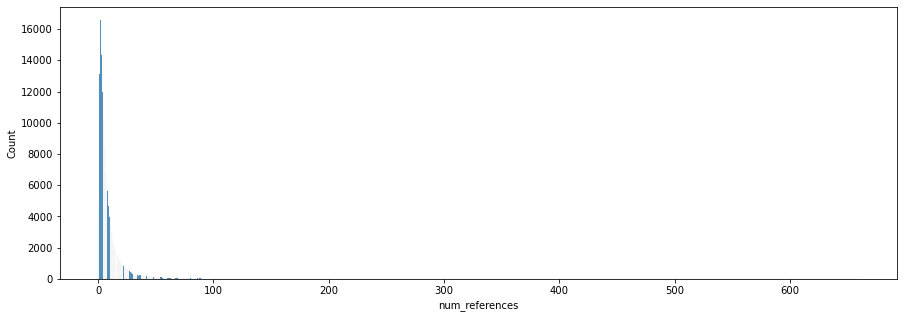

<IPython.core.display.Javascript object>

In [16]:
# Histplot of updated num_references
plt.figure(figsize=(15, 5))
sns.histplot(data=df, x="num_references")
plt.show()

#### Observations:
- The distribution of `num_references` remains highly right skewed.
- 25% of entries have 2 or fewer references, which may be a good cutoff to search for `known_for` values.
- Let us view the log transformation of the feature, both for the full dataset, and for `num_references` > 2.

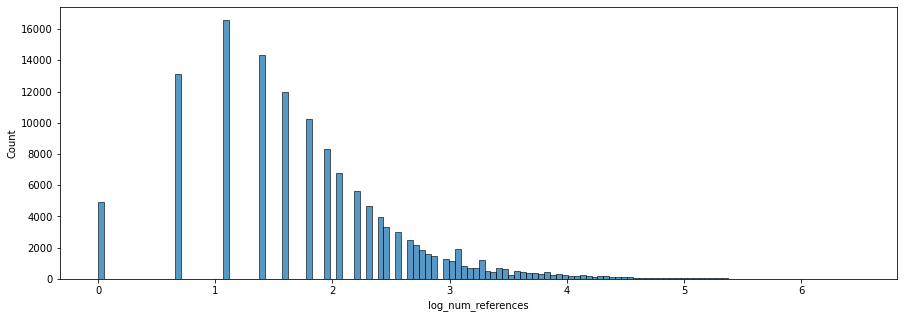

<IPython.core.display.Javascript object>

In [17]:
# Adding column for log_num_references
df["log_num_references"] = df["num_references"].apply(lambda x: np.log(x + 1))

# Histplot of log_num_references
plt.figure(figsize=(15, 5))
sns.histplot(data=df, x="log_num_references")
plt.show()

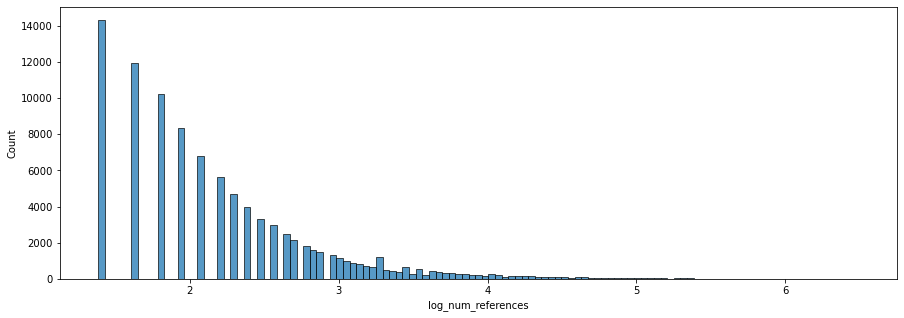

<IPython.core.display.Javascript object>

In [18]:
# Histplot of log_num_references where num_references > 2
plt.figure(figsize=(15, 5))
sns.histplot(data=df[df["num_references"] > 2], x="log_num_references")
plt.show()

#### Observations:
- The distribution is certainly more normalized with the log transformation, but follows a consistent curve for values > 2.
- For this analysis, we will focus on these more noted entries.

## Extracting `known_for` Data
Our goal will be to have some broader categories into which the specific values will fit.  `known_for` is a diverse feature, in that an individual may be known for a long-term role or roles, a specific event, a relationship with another person who is famous, etc.  So, to some extent we will see what we find and adapt as we go.

Also, we will abandon searching left to right as an individual may fit more than one category, and in no particular order.  For example, Ronald Reagan, is entered as "American actor and politician".  He is most known as the 40th president of The United States, so if we prioritized the first value, he would fit only into the category containing actor.  At the same time, it may have been his acting career that led to his political career.  Both arenas are relevant, so we will aim to capture all categories for an individual.  Later, when there are duplicate categories for an indivual, we can remove the redundant values.

We will take the following approach:
1. create and check a list of unique values in `info_2` that have a minimum number repeated, sufficient to create sets for each category, but not so exhaustive to be time prohibitive to manually enter.
2. using the pop() method, add each role to it's associated category's set, below.
3. combine the sets for each category into one dictionary.
4. Create a corresponding column for each category, initialized equal to 0.
4. search for the values in the dictionary and change the category column to 1 if match is found.

#### Restricting our Dataset to Entries with More than 2 References

In [19]:
# Limiting the dataset to entries with > 2 references
df = df[df["num_references"] > 2]
print(f"There are {len(df)} remaining entries in the dataframe.")

There are 98061 remaining entries in the dataframe.


<IPython.core.display.Javascript object>

#### Finding `known_for` Roles in `info_1`

In [20]:
# Obtaining values for column and their counts
roles_list = df["info_1"].value_counts().index.tolist()

<IPython.core.display.Javascript object>

In [ ]:
# # Code to check each value
# roles_list.pop()

#### Creating Lists for Each `known_for` Category

In [21]:
# Creating lists for each category
politics_govt_law = [
    "politic",
]

arts = ["choral", "conductor", "journalist", "artist"]
sports = [
    "basketball",
    "Olymp",
    "gymnast",
    "sprinter",
    "sports",
]
sciences = ["materials scientist", "social psychologist", "psychologist"]

business = [
    "businessman",
    "businesswoman",
    "business",
]
academia_humanities = []
law_enf_military_operator = []
spiritual = []
social = []
# 'terrorist' will need separate treatment
crime = []
event_record_other = []
other_species = [
    "Tree",
    "chimpanzee",
]

<IPython.core.display.Javascript object>

In [22]:
# # Example code to quick-screen values that may overlap categories
# df.loc[[index for index in df.index if "King" in df.loc[index, "info"]], :]

<IPython.core.display.Javascript object>

#### Observations:
- We have a small start on `known_for_dict` values for which to search.
- Note that some roles such as sportswriter and sports broadcaster, though associated with sports, will also be included in arts, to align with the underlying nature of the work itself.
- Notes will be made in comments when the order of the categories in the dictionary matters during the search.
- Let us combine them into one dictionary.
- It appears we can collect `other_species` as we go, rather than needing our prior list.

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Sets of Values

In [23]:
# Combining separate lists as sets into one dictionary
known_for_dict = {
    "social": set(social),
    "spiritual": set(spiritual),
    "academia_humanities": set(academia_humanities),
    "business": set(business),
    "sciences": set(sciences),
    "arts": set(arts),
    "sports": set(sports),
    "law_enf_military_operator": set(law_enf_military_operator),
    "politics_govt_law": set(politics_govt_law),
    "crime": set(crime),
    "event_record_other": set(event_record_other),
    "other_species": set(other_species),
}

<IPython.core.display.Javascript object>

#### Initializing `known_for` Category Columns

In [24]:
# Creating columns for each category
for category in known_for_dict:
    df[category] = 0

# Checking a sample
df.sample()

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,social,spiritual,academia_humanities,business,sciences,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species
63152,7,Thomas Fee,", 82, American politician, member of the Pennsylvania House of Representatives .",https://en.wikipedia.org/wiki/Thomas_Fee,3,2013,August,,None,politician,member of the House of Representatives,None,None,None,None,None,None,None,None,82.0,None,United States of America,None,1970 1994,1.386294,0,0,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

#### Extracting Category from `info_1`

In [25]:
%%time

# Column to check
column = 'info_1'

# Dataframe
dataframe = df[column].notna()

# For loop to find role in column and extract it as category
for category, category_set in known_for_dict.items():
    for role in category_set:
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, category] = 1
                    df.loc[index, column] = item.replace(role, '').strip()

# Checking a sample of rows
df[df['politics_govt_law'] ==1].sample(2)

CPU times: total: 12.1 s
Wall time: 12.1 s


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,social,spiritual,academia_humanities,business,sciences,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species
87054,8,Mohamud Muse Hersi,", Somali politician, 79–80, President of Puntland .",https://en.wikipedia.org/wiki/Mohamud_Muse_Hersi,12,2017,February,,ian,None,President of Puntland,None,None,None,None,None,None,None,None,79.5,None,Somalia,None,2005 2009,2.564949,0,0,0,0,0,0,0,0,1,0,0,0
6832,17,Spiro Agnew,", American politician, 77, 39th Vice President of the United States, leukemia.",https://en.wikipedia.org/wiki/Spiro_Agnew,207,1996,September,None,ian,None,th Vice President of the,leukemia,None,None,None,None,None,None,None,77.0,None,United States of America,None,None,5.337538,0,0,0,0,0,0,0,0,1,0,0,0


<IPython.core.display.Javascript object>

In [26]:
# Checking remaining values in `info_1`
df["info_1"].value_counts()

                  6
ian               2
ic                2
early             2
man               1
social            1
King of           1
leader            1
Jules Engel       1
Jr                1
common            1
player            1
college  coach    1
of the Year       1
Name: info_1, dtype: int64

<IPython.core.display.Javascript object>

#### Observations:
- Once again, the `info_1` column has provided a small sample on which to test our code, which appears to be working.
- We expect "King", "man", and "leader" to still be present, at this point.  There are some words, such as these, that used across different categories, so we will treat them carefully.
- When an entry has more than one role for the same category, the category value will still be equal to 1.
- We can proceed to `info_2`, which should have the bulk of the `known_for` information.

#### Finding `known_for` Roles in `info_2`

In [27]:
# Obtaining values for column and their counts
roles_list = df["info_2"].value_counts().index.tolist()

<IPython.core.display.Javascript object>

In [574]:
len(roles_list)

21882

<IPython.core.display.Javascript object>

In [570]:
"heaviest" in event_record_other

False

<IPython.core.display.Javascript object>

In [573]:
# Code to check each value
roles_list.pop()

'Catholic Bishop advocate of liberation theology'

<IPython.core.display.Javascript object>

#### Appending Lists for Each `known_for` Category

In [501]:
# Appending lists for each category
politics_govt_law = politics_govt_law + [
    "entertainment attorney litigator",
    "Law Lord",
    "textbook campaigner",
    "campaigner",
    "Prime Minister President",
    "Prime Minister",
    "First Lady of the",
    "Western Shoshone leader",
    "environmental activist",
    "healthcare activist political commentator",
    "activist",
    "Clerk of Courts",
    "Senate President",
    "leader of the FNLA",
    "Labour Party MP",
    "Labour Party",
    "MP",
    "Chief Justice",
    "Emperor",
    "Chairman of the Assembly of Experts",
    "anti war activist",
    "chief minister",
    "wife of acting President Raúl Castro",
    "Representative from",
    "Yukon Party Leader",
    "Yukon Party",
    "Party Leader",
    "mayor",
    "Chief Minister",
    "presidential advisor",
    "national President",
    "District Court judge",
    "Justice",
    "judge",
    "diplomat",
    "legislat",
    "Court",
    "civil rights leader",
    "civil rights",
    "rights",
    "former President Nasser",
    "detainee",
    "Legislative Council",
    "Legislat",
    "Attorney General",
    "real estate attorney",
    "attorney",
    "tribal chief",
    "endangered species  advocate",
    "litigator",
    "advisor to Henry Kissinger",
    "senator",
    "Princess",
    "Ambassador",
    "nuclear arms control advocate",
    "republican",
    "Governor",
    "federal prosecutor",
    "Representative",
    "lawyer",
    "Deputy  Chief of Staff",
    "Progressive",
    "Conservative",
    "public health official",
    "mayor",
    "labor law expert member of Presidential commissions",
    "Liberal",
    "Democrat",
    "peer",
    "House of Lords",
    "Provisional  Republican Army founder member Northern  Assembly member",
    "jurist",
    'Teachta Dála',
    'aristocrat',
    'congress member',
    'Radio Peace',
    'Secretary of Interior',
    'Senator for',
]

arts = arts + [
    "television",
    "singer",
    "artist theorist in Arte Povera movement",
    "game artist",
    "graffiti artist",
    "make up artist",
    "artist",
    "rock manager",
    "porn producer",
    "photography curator",
    "photograph",
    "singer",
    "show contestant",
    "show",
    "contestant",
    "guitarist",
    "bass guitar player",
    "guitar",
    "broadcaster",
    "writer",
    "radio",
    "dramatist",
    "stage actor",
    "actor",
    "folk",
    "newspaper",
    "news",
    "anchorman",
    "anchorwoman",
    "anchor",
    "architect acoustician",
    "architect",
    "novelist",
    "author",
    "rhythm & blues",
    "vocalist",
    "painter",
    "talk show host",
    "host",
    'editor in chief',
    "editor",
    "dance",
    "choreograph",
    "playwright",
    "jazz",
    "tuba",
    "composer",
    "military journalist",
    "cartoonist",
    "keyboardist",
    "managing director of BBC Radio",
    "critic",
    "violin",
    "bass player",
    "bassist",
    "rapper ",
    "announcer",
    "commentator",
    "creator of the Howdy Doody puppet",
    "video",
    "columnist",
    "theatre producer",
    "theatr",
    "theater",
    "musician",
    "poet",
    "commentator",
    "film producer",
    "film",
    "stage actress",
    "stage manager",
    "stage director",
    "actress",
    "sculptor",
    "diarist",
    "founder of Sonnabend Gallery",
    "stunt",
    "performer",
    "screen",
    "impresario",
    "soul funk",
    "artistic director",
    "expert on the pipe organ",
    "pipe organ",
    "organist",
    "quilting",
    "owner of Factory Records",
    "cultural functionary",
    "movie",
    "narrator",
    'beer expert',
    'gamelan',
    'scriptwriter',
    'cast member',
    'drum',
    'bandleader',
    'band leader',
    'opera',
    'defence correspondent',
    'correspondent'
]
sports = sports + [
    "who was oldest living AFL VFL footballer",
    "cricket",
    "umpire",
    "fencing",
    "baseball",
    "rugby union footballer",
    "rugby union winger",
    "rugby union",
    "rugby",
    "football manager",
    "football",
    "wrestler",
    "Rodeo",
    "hiking",
    "athlet",
    "rower",
    "NHL",
    "drag racing",
    "hot rod",
    "swim",
    "World Rally",
    "motorcycle racer",
    "MotoGP racer",
    "explorer",
    "cheerleader",  # Contains leader
    "CEO of soccer club",
    "soccer",
    "former general manager of Montreal Canadiens",
    "yokozuna",
    "bush walker",
    "wrestl",
]
sciences = sciences + [
    "physicist",
    "scientist in the field of human consciousness",
    "cognitive behavioral therapy",
    "researcher in artificial intelligence",
    "artificial intelligence",
    "engineer",
    "geneticist",
    "developmental biologist",
    "biologist",
    "acoustician",
    "electronics innovator",
    "polio cancer researcher",
    "astronomer",
    "atmospheric scientist",
    "meteorologist",
    "chemist",
    "information researcher",
    "radiolog",
    "director of SLAC",
    "who built Alaska first television station",  # Must go before arts
    "doctor",
    "inventor of the Nautilus exercise machines",
    "sociologist",
    "psychiatrist",
    "inventor",
    "bee expert",
    'medical scientist',
    'scientist',   #  Double-chec
    'ornitholog'
]

business = business + [
    "Matchbox Toys",
    "retail pioneer",
    "executive at MGM",
    "stockbroker",
    "founder of Bob Evans Restaurants",
    "banker",
    "labor leader",
    "chairman owner of Ellen Tracy sportswear",
    "founder of Princess Cruises",  # Must go before politics_govt_law
    "inventor of Rice a Roni",  # Must go before sciences if inventor in sciences
    "entrepreneur",
    "home builder",
    'farm'
]
academia_humanities = academia_humanities + [
    "scholar translator of  literature",  # Contains translator
    "Jewish Holocaust historian",  # Must come before spiritual
    "military historian",  # Must come before law_enf_military_operator
    "historian",
    "literary scholar",
    "scholar",
    "idealist philosopher",
    "social philosopher",
    "philospher",
    "idealist",
    "president of the University",
    "professor",
    "Professor",
    "expert on Latin",
    "curator",
    "archivist",
    "President of Gadjah Mada University",
]
law_enf_military_operator = law_enf_military_operator + [
    "army general",
    "army",
    "Taliban commander",
    "commander",
    "representative of the Abraham Lincoln Brigade",
    "soldier",
    "fighter pilot",
    "Air Force",
    "general for South  during the  War",
    "security agent",
    "marine",
    "Marine",
    "Medal of Honor",
    "World War II",
    "leader of the Anbar Salvation Council",
    "leader of Anbar Salvation Council",
    "airforce major general",
    "major general",
    "Air Marshal",
    "Army Officer",
    "intelligence service",
    "aviation",
    "security guard",
    'guerrilla'
]
spiritual = spiritual + [
    "Nonconformist minister",
    "cleric",
    "Jewish  Catholic Archbishop Emeritus of Paris",
    "Jewish",
    "Catholic",
    "Archibishop",
    "Patriarch of the  Orthodox Church",
    "Protopresbyter  of the  Orthodox Church",
    "Orthodox Church",
    "abbot",
    "evangelist",
    "theologian",
    "priest",
    "Anglican",
    "archbishop",
    "Protestant minister",
    "Protestant",
    "Archbishop",
    "religious mystic",
    "mystic",
    "rabbi",
    "chaplain",
    "second counselor in the First Presidency of the LDS Church",
    "evangel",
    "pastor",
]
social = social + ["socialite",'philanthrop']
crime = crime + [
    "accused of involvement in attempt by Mehmet Ali Ağca to kill Pope John Paul II",
    "terrorist involved in the  Glasgow International Airport attack",
    'leader of the " Mafia"',
    "jailed for human rights abuses under Pinochet",
    "alleged child sex offender",
    'arranged the murder of his mistress'
]
event_record_other = event_record_other + [
    "oldest",
    "graduate",
    "Taliban hostage",
    "Son of Chris Benoit Nancy Benoit",
    "hate crime victim",
    "victim",
    "phone phreak",
    "survivor",
    "witness",
    "wrongly accused of the Atlanta Olympics bombing",
    'heaviest'
]
other_species = other_species + [  # Must go after sports and arts
    "search rescue dog for September",
    "sacred bull",
    "thoroughbred racehorse",
    "orca at SeaWorld San Antonio",
    "orca",
    "parrot",
]

<IPython.core.display.Javascript object>

In [524]:
# Example code to quick-screen values that may overlap categories
df.loc[
    [index for index in df.index if "beer expert" in df.loc[index, "info"]], :,
]

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,social,spiritual,academia_humanities,business,sciences,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species
33965,30,Michael Jackson,", 65, British writer and beer expert , heart attack.",https://en.wikipedia.org/wiki/Michael_Jackson_(writer),16,2007,August,,None,writer beer expert,heart attack,None,None,None,None,None,None,None,None,65.0,None,United Kingdom of Great Britain and Northern Ireland,None,,2.833213,0,0,0,0,0,0,0,0,0,0,0,0
76950,10,Fred Eckhardt,", 89, American beer expert.",https://en.wikipedia.org/wiki/Fred_Eckhardt,20,2015,August,None,None,beer expert,None,None,None,None,None,None,None,None,None,89.0,None,United States of America,None,None,3.044522,0,0,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

In [559]:
df[df["info_2"] == "defence correspondent for"]

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,social,spiritual,academia_humanities,business,sciences,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species
32522,2,Ivan Safronov,", 51, Russian defence correspondent for , fall from building.",https://en.wikipedia.org/wiki/Ivan_Safronov,14,2007,March,None,None,defence correspondent for,fall from building,None,None,None,None,None,None,None,None,51.0,None,Russia,None,None,2.70805,0,0,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

In [300]:
# Dropping entries that have <3 num_references due page is for event, etc.
links_to_drop = ['https://en.wikipedia.org/wiki/Vivienne_Nearing']

<IPython.core.display.Javascript object>

In [331]:
# Simplifying atypical value containing additional website
index = df[df["link"] == "https://en.wikipedia.org/wiki/Wyn_Harness"].index
df.loc[index, "info_2"] = "journalist"

<IPython.core.display.Javascript object>

In [ ]:
# Extracting "dog attack" to cause_of_death to avoid other_species inclusion
index = df[df["link"] == "https://en.wikipedia.org/wiki/Death_of_Diane_Whipple"].index
df.loc[index, "cause_of_death"] = "dog attack"
df.loc[index, "info_3"] = None

In [ ]:
# Extracting administrator as academia_humanities to known_for_1
index = df[
    df["link"] == "https://en.wikipedia.org/wiki/John_Blackburn_(educator)"
].index
df.loc[index, "known_for_1"] = "academia_humanities"
df.loc[index, "info_2"] = None

In [ ]:
# Removing administrator from entry as category will be captured with other info
index = df[df["link"] == "https://en.wikipedia.org/wiki/John_E._Otto"].index
df.loc[index, "info_2"] = None

In [ ]:
# Extracting "complications of diverticulitis" to cause_of_death to remove "diver" from value
index = df[df["link"] == "https://en.wikipedia.org/wiki/Emanuel_Steward"].index
df.loc[index, "cause_of_death"] = "complications of diverticulitis"
df.loc[index, "info_3"] = None

In [ ]:
# Assigning arts to first known_for value for entry (individual is associated with arts and politics_govt_law)
index = df[df["link"] == "https://en.wikipedia.org/wiki/Pavel_Dost%C3%A1l"].index
df.loc[index, "info_1"] = "arts"

In [ ]:
# Removing minister from entry as category will be captured with other info
index = df[df["link"] == "https://en.wikipedia.org/wiki/Jean_Chamant"].index
df.loc[index, "info_2"] = None

In [ ]:
# Assigning law_enf_military_operator to entry with woman to serve in Foreign Legion
index = df[df["link"] == "https://en.wikipedia.org/wiki/Susan_Travers"].index
df.loc[index, "known_for_1"] = "law_enf_military_operator"
df.loc[index, "info_2"] = None

In [ ]:
print("dunzo!")
chime.success() 


In [21]:
# Appending lists for each category
politics_govt_law = politics_govt_law + [
]

arts = arts + []
sports = sports + [
    
]
sciences = sciences + []

business = business +  [

]
academia_humanities =  academia_humanities + []
law_enf_military_operator = law_enf_military_operator + []
spiritual = spiritual + []
social = social + []
crime = crime + []
event_record_other = event_record_other + []
other_species = other_species +  [
]

<IPython.core.display.Javascript object>